In [20]:
import numpy as np
import matplotlib.pyplot as plt
import nlpde_utils

from scipy.linalg import eig
from scipy.optimize import fsolve,root,approx_fprime

import contourpy


# Computation of eigenvalues and eigenfunctions

## General
The eigenvalue loci are the curves in the $(\bar\alpha, \omega)$-plane shown in the main text, Fig. 2.

The eigenvalues $\omega_n$ and corresponding eigenfunctions $u_n$ are solutions of the integrodifferential eigenvalue equation
$$ (\partial_{xx} - \bar\alpha \partial_x\mathcal{A}) u = \omega u, \qquad \left.(\partial_{x} - \bar\alpha \mathcal{A}) u\right|_{x=0,\ell}=0 $$
where
$$ \mathcal{A}(u)(x) = \int_0^\ell \tilde g(x'-x) u(x') dx$$
and
$$\tilde g(s) = \mathrm{sign}(s) g(s),$$
with $g$ denoting the interaction kernel.

In this paper, we use
$$ g(s) = e^{-s}.$$

There are different ways of calculating the eigenvalue curves
1) Direct numerical by discretization of the eigenvalue problem
2) Using the algebraic equations derived analytically
3) Using the pertubation calculations (these are approximations)

Below we show code for (1) and (2), and we will use (3) to check the results.

In Fig. 2 in the main text, we also show a *regime diagram*, indicating the lines in the $(\ell, \bar\alpha)$-plane where each spatial mode becomes unstable. At the end of this notebook we show the code for drawing this.


-------------------------

## Direct numerical calculation

We can discretize the eigenvalue equation directly, and use classical eigenvalue algorithms for matrices.

We do the discretization on a Chebyshev grid $x_j, j=0\ldots N$.

The differentiation matrix $D$ is computed as in the Trefethen book. The matrix corresponding to $\mathcal{A}$ is computed entry by entry:
$$ A_{ij} = \int_0^\ell g(y-x_i)p_j(y) dy$$
where $p_j$ is the polynomial interpolating a delta function at $x_j$.

We compute these integrals in two ways, either using scipy's quadrature function. Much faster, however, is to approximate the integral by Clenshaw-Curtis quadrature using the Chebyshev points, in this case
$$ A_{ij} \approx g(y_j-x_i) w_j$$
where $w_j$ is the Clenshaw-Curtis weight.

**Note** Because $\tilde g$ is not continuous, the Clenshaw-Curtis approxiation is not super accurate especially for lower $N$. 
The matrix does depend on $\ell$ only, so we can compute it once using the quadrature method if we are only varying $\bar\alpha$. 

### Generalized eigenvalue problem

The eigenvalue problem in discretized form is 
$$ D(D-\bar\alpha A) u = \omega u.$$
However, we have the boundary conditions. We implement these by going to the generalized eigenvalue problem 
$$ M u = \omega Bu$$, 
where $M$ is $D^2  - \bar\alpha DA$, but the first and last row of $M$ are replaced by the first and last rows of $D - \bar\alpha A$, and the matrix $B$ is the identity matrix, but with zeros on the first and last row.

In [19]:
##### TEST two ways of computing the matrix A
alphabar = 4
ell = 5
N=20
def g(x):
    return np.exp(-x)

_, x= nlpde_utils.cheb(N) ## get interpolation points
### rescale
x = (x+1)/2 * ell

%time A1 = nlpde_utils.get_A_cheb(x, g, ell, method='quad')
%time A2 = nlpde_utils.get_A_cheb(x, g, ell, method='clencurt')


CPU times: user 1.6 s, sys: 0 ns, total: 1.6 s
Wall time: 1.6 s
CPU times: user 262 µs, sys: 0 ns, total: 262 µs
Wall time: 257 µs


max difference: 0.07030485399950387


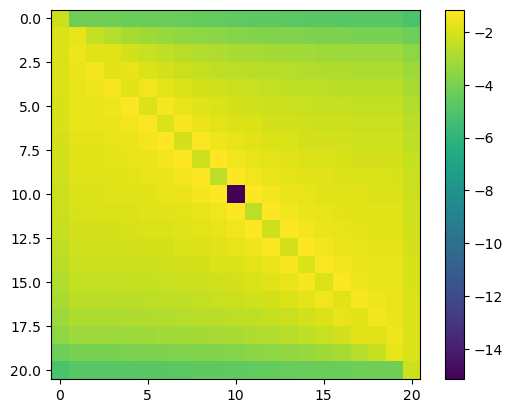

In [20]:
print("max difference: {}".format(np.max(abs(A1-A2))))
plt.imshow(np.log10(abs(A1-A2)))
plt.colorbar()

In [24]:
### eigenvalues for a single value of alphabar

alphabar = 4
ell=3

N=30 #### note that x and the matrices have dimensions N+1 (Cheby convention)
def g(x):
    return np.exp(-x)

D, x= nlpde_utils.cheb(N) ## get interpolation points
### rescale
D = D*2/ell
x = (x+1)/2 * ell
## matrix of the nonlocal operator
A = nlpde_utils.get_A_cheb(x, g, ell, method='quad')

M0 = D - alphabar*A
M = D@M0
## first and last row
M[0,:] = M0[0,:]
M[-1,:] = M0[-1,:]
### right hand side
B = np.eye(N+1)
B[0,0]=0
B[-1,-1]=0

### generalized eigenvalue problem
eival, eivec = eig(M,B)
# remove infinity
idxinf = np.isinf(eival)
eival = eival[~idxinf]
eivec = eivec[:,~idxinf]

# order from high to low
idxsort = np.argsort(eival)[-1::-1]
eival=eival[idxsort]
eivec=eivec[:,idxsort]

In [27]:
eival

array([ 1.83806644e+00+0.j,  1.38338889e+00+0.j, -4.18544986e-14+0.j,
       -3.19527423e+00+0.j, -1.02505427e+01+0.j, -1.99041904e+01+0.j,
       -3.18020448e+01+0.j, -4.59856763e+01+0.j, -6.23677814e+01+0.j,
       -8.09788412e+01+0.j, -1.01780526e+02+0.j, -1.24793425e+02+0.j,
       -1.49995339e+02+0.j, -1.77407880e+02+0.j, -2.07025640e+02+0.j,
       -2.38711064e+02+0.j, -2.72095173e+02+0.j, -3.11014911e+02+0.j,
       -3.45474398e+02+0.j, -4.02698967e+02+0.j, -4.12847117e+02+0.j,
       -5.82522575e+02+0.j, -5.96029433e+02+0.j, -8.98429660e+02+0.j,
       -9.01415748e+02+0.j, -1.96963584e+03+0.j, -1.99081356e+03+0.j,
       -5.16302581e+03+0.j, -5.17658343e+03+0.j])

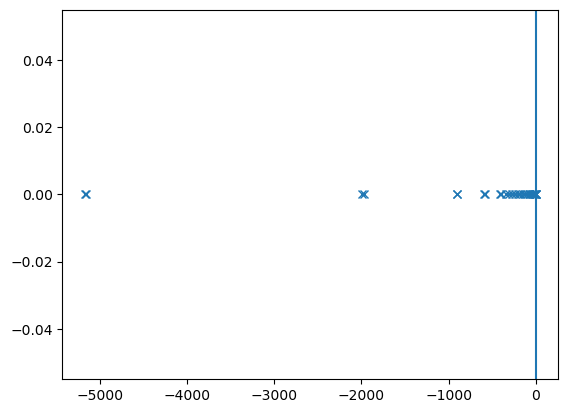

In [29]:
### plot the eigenvalues
plt.plot(eival.real, eival.imag, 'x')
plt.axvline(0)

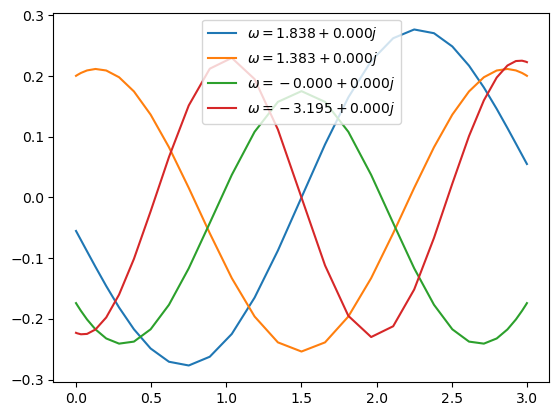

In [33]:
## show a few of the eigenfunctions
for i in range(4):
    plt.plot(x, eivec[:,i], label=r'$\omega = {:.3f}$'.format(eival[i]))
plt.legend()

## Calculation of the eigenvalue curves by numerical contination on the discretized problem

Given $N$, the eigenvalue equation 
$$ M u = \omega B u$$
with $M$ defined as $D^2 -\bar\alpha DA$ except for the first and last row (see above), is actually a set of $N+1$ algebraic equations in the variables $\omega$ and $u_i$, $i=0\ldots N$. Because eigenvectors are defined up to scalar multiplication, we can add one extra equation such as 
$$||u||_2 = 1$$
to obtain a set of $N+2$ equations in $N+2$ variables. The solutions are points $\omega, u$. We can then vary $\bar\alpha$ and track the $\omega, u$ solutions as function of $\bar\alpha$, thus calculating the eigenvalue curves. We do this by pseudo-arclength continuation (see Kuznetsov's book).

We know that for $\bar\alpha=0$, the eigenvalues are $\omega_n = -(n\pi/\ell)^2$ with $u_j = \cos(n\pi/\ell x_j)$. This can be used as the starting point for the continuation 

In [41]:
############## setup
def g(x):
    return np.exp(-x)
N = 50 # there will be N+1 differentiation points
L = 5
# matrices
D, x = nlpde_utils.cheb(N)
x = (x+1)*L/2
D *= 2/L

A = nlpde_utils.get_A_cheb(x, g, L, 'clencurt') ### use clencurt for speed

### minimal and maximal stepsize to use in the continuation
hmin = 1e-2
hmax = 0.2

def F(X):
    ##### Define the function whose zeros we need to follow
    # contains eigenvector, eigenvalue and alphabar
    u = X[:-2]
    omega = X[-2] # eigenvalue
    alphabar = X[-1]
    
    res = np.zeros(len(X)-1)
    res[:-1] = D@D@u - alphabar*D@A@u - omega*u ### eigenvalue problem
    res[0] = ((D-alphabar*A)@u)[0] #### boundary conditions
    res[-2] = ((D-alphabar*A)@u)[-1]
    res[-1] = np.linalg.norm(u)-1 # normalization condition
    return res
def predict(Xold,vold,h):
    #### compute also the current tangent vector v. For this we need vold for a full set of equatons
    JF = approx_fprime(Xold,F,epsilon=1e-6) # shape N+2 times N+3
    M = np.zeros((len(Xold), len(Xold)))
    M[:-1,:] = JF
    M[-1,:] = vold
    b = np.zeros(len(Xold))
    b[-1] = 1
    v = np.linalg.solve(M, b)
    v /= np.linalg.norm(v)
    return Xold + v*h, v

def correct(Xp, v):
    # Xp is 'predicted', i.e. the guess to be corrected.
    # v is tangent at previous point, correct along direction orthogonal to v
    def tosolve(y):
        return np.hstack((F(y), np.dot(v, y-Xp)))
    Xc, infodict, _, _ =fsolve(tosolve, Xp, full_output=True, xtol=1e-14)
    ### returns the corrected point as well as the number of function evaluations fsolve had to do (to adapt step size)
    return Xc, infodict['nfev']
    
def get_branch(n,h,Nsteps):
    """ get the branch emanating from the nth eigenvalue -(n*pi/L)^2 at alphabar=0"""
    # start at the known eigenfunction of the laplacian, cosine
    w0 = np.cos(n*np.pi/L*x)
    l0 = -(n*np.pi/L)**2
    alphabar0 = 0
    X0 = np.hstack((w0,l0,alphabar0))
    v0 = np.zeros_like(X0)
    v0[-1] = 1 # tangent vector. Go to larger alphabar, so start with positive number in last position (will be corrected to tangent)

    #### lists will contain the whole branch
    XX = [X0]
    vv = [v0]

    ### step size, will be updated throughout
    hh = h 

    ##### calculate the whole branch
    for i in range(Nsteps):
        Xpred, vold = predict(XX[-1],vv[-1],hh)
        Xcorr,nfev = correct(Xpred, vold)
        XX.append(Xcorr)
        vv.append(vold)
        vv[-2] = vold

        #### naive step-size adaptation depending on the number of function evaluations done
        if nfev<5 and hh< hmax:
            hh *=1.1
        if nfev>15 and hh>hmin:
            hh /= 1.1
    return XX, vv


In [42]:
#### calculate a few branches, may take some time
branches = {}
for n in range(1, 8):
    print(L,n)
    branches[n] = (get_branch(n, 0.05, 2000))

5 1
5 2
5 3
5 4
5 5
5 6
5 7


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_48052/1655819287.py:21: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel("Eigenvalue $\omega$")


Text(0.5, 1.0, '$L = 5$')

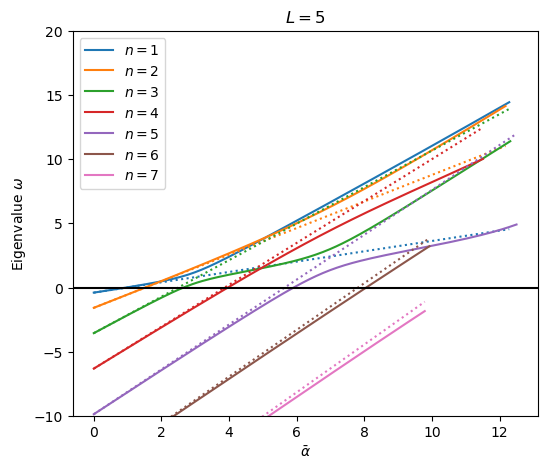

In [49]:
### plot the results and add the perturbation calculation for verification
fig, ax = plt.subplots(figsize=(6,5))

for n in branches.keys():
    skip=10 ### don't plot all points
    XXX = np.array(branches[n][0])[::skip,:]
    vvv = np.array(branches[n][1])[::skip,:]
    alphabarv = XXX[:,-1]
    omegav = XXX[:,-2]

    l,=ax.plot(alphabarv,omegav, label=r'$n={}$'.format(n))

    if 1: # add results from perturbation
        l0 = -(n*np.pi/L)**2
        l1 = -2*l0/(1-l0)**2*(1-l0 - 2/L*(1 - (-1)**n*np.exp(-L)))
        ax.plot(alphabarv, l0+alphabarv*l1, ':', color=l.get_color())
ax.axhline(0, color='k')
ax.legend()
ax.set_xlabel(r"$\bar\alpha$")
ax.set_ylabel("Eigenvalue $\omega$")
if 0:
    # zoom
    ax.set_xlim(0,5)
    ax.set_ylim(-2,2)
else:
    ax.set_ylim(-10, 20)
ax.set_title("$L = {}$".format(L))


## Analytical calculation

We have shown that, for the exponentially decaying interaction kernel, the eigenvalues $\omega$ need to be solutions of 
$$
\begin{aligned}
    w_1^2 + (2\bar\alpha - 1 - \omega)w_1 + \omega &= 0\\
    w_2^2 + (2\bar\alpha - 1 - \omega)w_2 + \omega &= 0\\
    \zeta(\sqrt{w_1})\gamma(\sqrt{w_2}) - \zeta(\sqrt{w_2})\gamma(\sqrt{w_1}) &= 0. 
\end{aligned}
$$
in which 
\begin{align}
         \zeta(z) &= \frac{e^{\frac{\ell z}{2}}}{z-1} - (-1)^n \frac{e^{-\frac{\ell z}{2}}}{z+1}   \\
\gamma(z) &= \frac{e^{-\frac{z \ell}{2}} - (-1)^n e^{\frac{z \ell}{2}}}{z}. 
\end{align}
The value of $n$ denotes the parity of the eigenfunction. So for $n$ odd, the solutions of the equations will yield $\omega_1, \omega_3, \omega_5, \ldots$ and for $n$ even it will give $\omega_0, \omega_2$ etc.

This means we can find $\omega$, for fixed $\ell$ and $\bar\alpha$, by solving the set of equations for $w_1, w_2$ and $\omega$. The eigenfunctions $u$ can be found from $w_1, w_2, \omega$. 

We use these equations to determine the eigenvalue loci using numerical continuation: knowing $\omega, w_1, w_2$ for one $\bar\alpha$, we can vary $\bar\alpha$ slightly and then recompute the solution to the equation, thereby following the curves in the $(\bar\alpha, \omega)$ plane. 

We start each eigenvalue branch from $\bar\alpha$ close to zero, where we know analytically the solution. 

#### Practical note
The third equation can be rewritten in different ways. After some trial and error, using 
$$ \frac{\zeta(z_1)}{\gamma(z_1)} - \frac{\zeta(z_2)}{\gamma(z_2)} = 0$$
seemed to work best. 

In [57]:
######## setup
L = 5

def zeta(z,n):
    return np.exp(L*z/2)/(z-1)- (-1)**n*np.exp(-L*z/2)/(z+1)
def gamma(z,n):
    return 1/z*(np.exp(-z*L/2) - (-1)**n*np.exp(L*z/2))
def gamma_over_zeta(z, n):
    return (np.exp(-L*z) - (-1)**n)/z/(
        1/(z-1) - (-1)**n*np.exp(-L*z)/(z+1))

def F(X,n):
    """ X is vector of w1,w2, lambda, alphabar. Returns 3 eq"""
    w1, w2, omega, alphabar =X
    
    quadratic1 = w1**2 + (2*alphabar-1-omega)*w1 + omega
    quadratic2 = w2**2 + (2*alphabar-1-omega)*w2 + omega
    z1 = np.sqrt(w1+0*1j)
    z2 = np.sqrt(w2+0*1j)
    extra_condition = 1/gamma_over_zeta(z1, n).real - 1/gamma_over_zeta(z2, n).real
    return [quadratic1, quadratic2, extra_condition]

### predictor corrector
# set up the continuation
#### note we have to give n as arguments, because the function F is different for the odd and even branches
def predict(n,Xold,vold,h):
    #### compute the current tangent vector v. For this we need vold for a full set of equatons
    JF = approx_fprime(Xold,lambda x:F(x,n),epsilon=1e-8) # shape N times N+1
    M = np.zeros((len(Xold), len(Xold)))
    M[:-1,:] = JF
    M[-1,:] = vold
    b = np.zeros(len(Xold))
    b[-1] = 1
    v = np.linalg.solve(M, b)
    v /= np.linalg.norm(v)
    return Xold + v*h, v
def correct(n,Xp, v):
    # Xp is 'predicted', i.e. the guess to be corrected.
    # v is tangent at previous point, correct along direction orthogonal to v
    def tosolve(y):
        return np.hstack((F(y,n), np.dot(v, y-Xp)))
    Xc, infodict, _, _ = fsolve(tosolve, Xp, full_output=True, xtol=1e-12)
    return Xc, infodict['nfev']

In [58]:
#### calculate different brances
nvals = np.arange(1, 8)
branches = {}
alphabar_max = 15 #### to stop the calculation


### max and min step size
maxh=0.5
minh=1e-2

for n in nvals:
    print(n)
    # start
    omega0 = -(np.pi*n/L)**2
    w1 = 1.001
    w2 = omega0+0.0001
    alphabar0=0.0001
    X0 = [w1, w2,omega0,alphabar0]
    
    # do a correct already, since we don't start exactly at a solution
    X0c = fsolve(lambda x: F(np.hstack((x, alphabar0)),n), X0[:-1])
    X = np.hstack((X0c, alphabar0))
    
    vstart = np.zeros(4)
    vstart[-1]=.1 #### to the right

    Nsteps = 2000
    h=0.03 #### initial step size, can change throughout
    

    XX = [X]
    vv = [vstart]
    for i in range(Nsteps):
        X_predicted, v = predict(n,XX[-1], vv[-1], h)
        X_corrected,nfev = correct(n,X_predicted,v)

        #### naive step length change based on function evaluations needed
        if nfev>9 and h>minh:
            h /= 1.1
        if nfev<4 and h<maxh:
            h *= 1.1

        XX.append(X_corrected)
        vv.append(v)
        vv[-2]= v

        #### break off computation if alphabarmax is reached
        if X_corrected[-1]>alphabar_max:
            break
            
    #### save the results
    branches[n] = (XX.copy(), vv.copy())


1


/tmp/ipykernel_48052/1872242559.py:21: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  X0c = fsolve(lambda x: F(np.hstack((x, alphabar0)),n), X0[:-1])


2
3
4
5
6
7


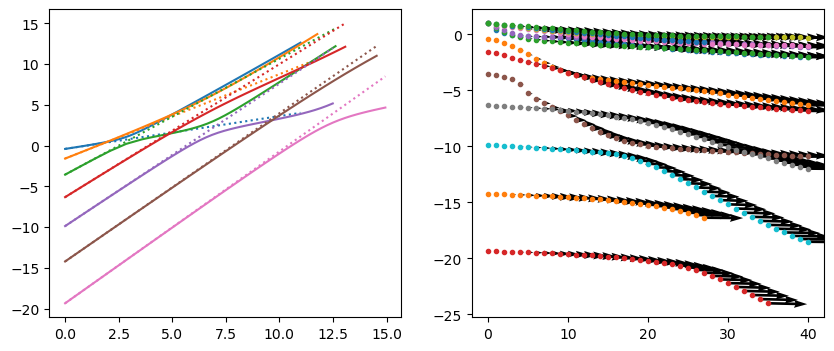

In [66]:
############## PLot results
fig, axes  = plt.subplots(1, 2, figsize=(10, 4))
for n in branches.keys():
    skip=50
    XXX = np.array(branches[n][0])[::skip,:]
    vvv = np.array(branches[n][1])[::skip,:]
    alphabarv = XXX[:,-1]
    omegav = XXX[:,-2]
    z1v = np.sqrt(XXX[:,0]+0*1j) #XXX[:,0]+ 1j*XXX[:,1]
    z2v = np.sqrt(XXX[:,1]+0*1j) #XXX[:,2]+ 1j*XXX[:,3]
    
    l, = axes[0].plot(alphabarv, omegav, '-')
    steps = np.arange(0, XXX.shape[0])

    if 1: # add results from perturbation
        l0 = -(n*np.pi/L)**2
        l1 = -2*l0/(1-l0)**2*(1-l0 - 2/L*(1 - (-1)**n*np.exp(-L)))
        axes[0].plot(alphabarv, l0+alphabarv*l1, ':', color=l.get_color())
        

    # zvalues
    if 0:
        axes[1].plot(z1v.real, 'x')
        axes[1].plot(z1v.imag, '.')
        axes[1].plot(z2v.real, 'x')
        axes[1].plot(z2v.imag, '.')
        #axes[1].quiver(steps, z1v.real, steps, vvv[:,0])
        #axes[1].quiver(steps, z1v.imag, steps, vvv[:,1])
    # or w values
    else:
        axes[1].plot(XXX[:,0], '.')
        axes[1].plot(XXX[:,1], '.')
        axes[1].quiver(steps, XXX[:,0], steps, vvv[:,0])
        axes[1].quiver(steps, XXX[:,1], steps, vvv[:,1])
    
#axes[0].set_xlim(0, 20)
#axes[0].set_ylim(-10, 20)

# Regime diagrams

To draw the regime diagram, we need to determine parameter values such that $\omega=0$ is a solution of the eigenvalue equation. In the supplementary materials, we show analytically that this leads to the equation
$$ \zeta(z) = 0, z = \sqrt{1-2\bar\alpha}$$


### Straightforward way

We can draw the zero contours of the function $\zeta$: create a grid of $\bar\alpha, \ell$ values, compute $\zeta$ for each, and draw the lines where $\zeta=0$.

Since $\zeta(z)$ is complex, we need to to a little adjustment. We observe that for even $n$, $\zeta(z)$ is purely real whereas for odd $n$ it is purely imaginary. So we can take real/imaginary parts and set them to zero in order to draw the instability lines for even /odd modes. 

**Note** this seems to yield one spurious curve, probably corresponding to $n=0$. This does not correspond to an instability curve, so we leave this one out.


### Analytical, direct way
We know that all solutions have imaginary $z = ix$. 
Since 
$$ \frac{e^{\frac{\ell z}{2}}}{z-1} - (-1)^n \frac{e^{-\frac{\ell z}{2}}}{z+1} , $$
we can rewrite the equation to 
$$ e^{i (n\pi + \ell x)} = \frac{ix-1}{ix+1}.$$
Both sides are expressions that map a number $x$ to a point on the unit circle. Even more, the right hand side defines a bijection between the real line and the unit circle in the complex plane. This allows a parameterization of the solution; pick a point $e^{i\theta}$ on the unit circle. From this we calculate $x$ as 
$$ x = -i \frac{1+e^{i\theta}}{1-e^{i\theta}}, $$
and $\bar\alpha = \frac{1}{2}(z^2 + 1) = \frac{1}{2} (1-x^2)$.
Given $x$ and $\theta$, $\ell$ is found as $\ell = (\theta - n\pi)/x$. 

Note that positive solutions for $\ell$ are only possible for $\theta \in [-\pi, 0]$, so we restrict to those values for the parametrization. 

### From the perturbation solution

The approximation
$$ \omega_n \approx \omega_n^0 + \bar\alpha \omega_n^1 $$
directly yields that, for $\omega_n$ to be zero, we need
$$ \bar\alpha = - \frac{\omega_n^0}{\omega_n^1}$$
in which both $\omega_n^0$ and $\omega_n^1$ depend on $\ell$. Since we have explicit expressions for $\omega_n^0$ and $\omega_n^1$, this is straightforward to plot.

<>:59: SyntaxWarning: invalid escape sequence '\e'
<>:59: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_43704/2543962057.py:59: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('System size $\ell$')
/tmp/ipykernel_43704/2543962057.py:43: RuntimeWarning: divide by zero encountered in divide
  xv = -1j *(1+np.exp(1j*thetav))/(1-np.exp(1j*thetav))
/tmp/ipykernel_43704/2543962057.py:43: RuntimeWarning: invalid value encountered in divide
  xv = -1j *(1+np.exp(1j*thetav))/(1-np.exp(1j*thetav))
/tmp/ipykernel_43704/2543962057.py:44: RuntimeWarning: invalid value encountered in divide
  Lv_par = (thetav - n*np.pi)/xv


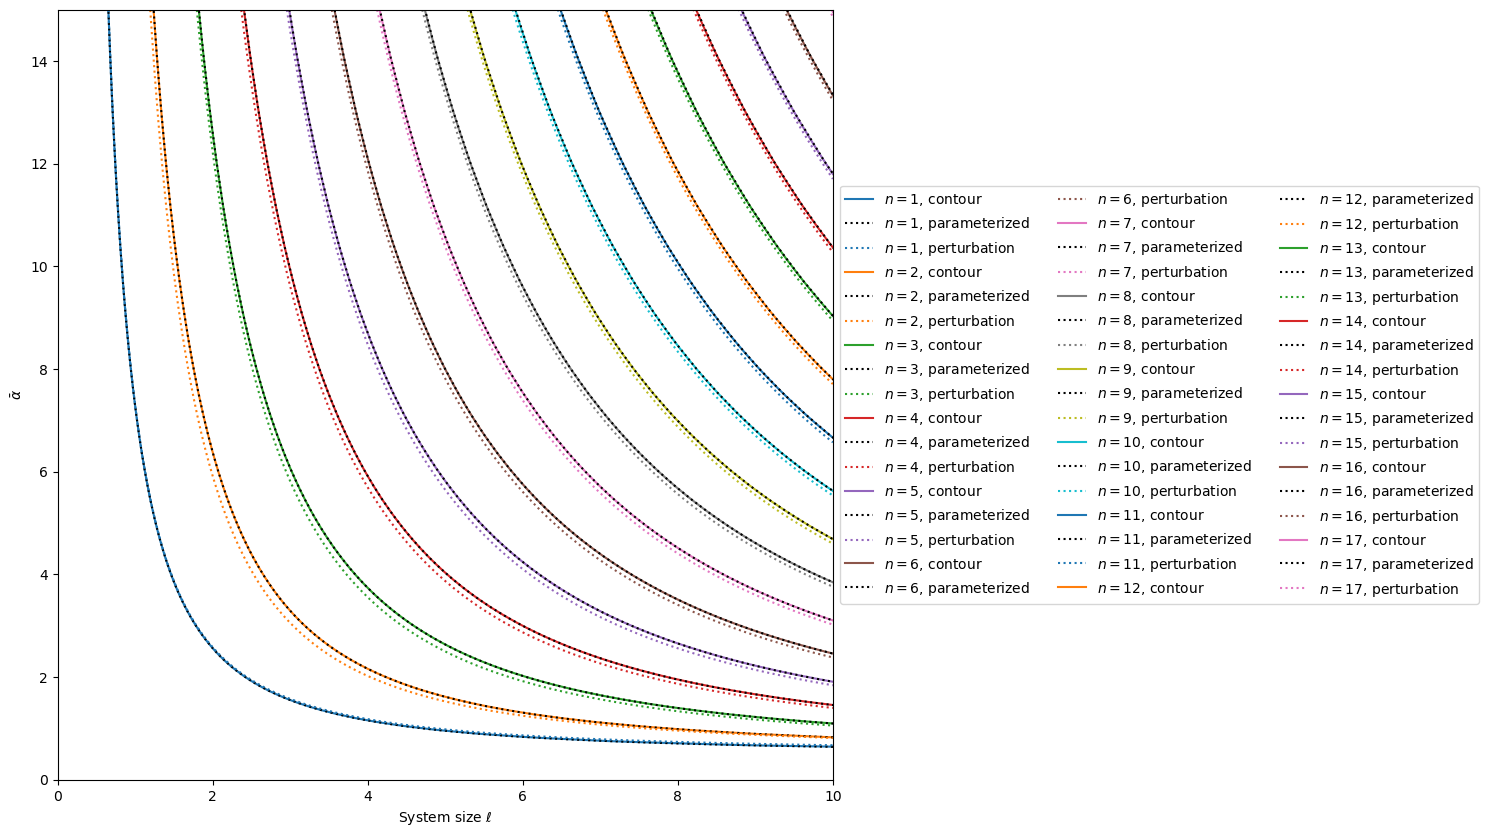

In [33]:
### show the three different methods on one plot (contour method and exact analytical method will overlap)

alphabarv = np.linspace(1e-6,15,201)
Lv = np.linspace(1e-6,10,201)

aa,LL = np.meshgrid(alphabarv,Lv)

fig, ax = plt.subplots(figsize=(10,10))

zz = np.sqrt(1-2*aa+0*1j)

### odd
Fo = (np.exp(LL/2*zz)/(zz-1) + np.exp(-LL/2*zz)/(zz+1)).imag
### even
Fe = (np.exp(LL/2*zz)/(zz-1) - np.exp(-LL/2*zz)/(zz+1)).real

## get contours
cont_gen_even = contourpy.contour_generator(LL,aa,Fe)
cont_gen_odd = contourpy.contour_generator(LL,aa,Fo)

lines_even = cont_gen_even.lines(0)
lines_odd = cont_gen_odd.lines(0)
all_lines = lines_even+lines_odd

# sort based on distance from the origin
dists = []
for l in all_lines:
    di_sq = np.min(l[:,0]**2 + l[:,1]**2)
    dists.append(di_sq)
ind_sorted =np.argsort(dists)
all_lines_sorted = [all_lines[ind_sorted[i]] for i in range(len(ind_sorted))]

# get rid of the first one (spurious)
del all_lines_sorted[0]

for i,lxy in enumerate(all_lines_sorted):
    n = i+1 #order of the eigenvalue
    l, = ax.plot(lxy[:,0], lxy[:,1], label='$n={}$, contour'.format(n))

    ########## add the parameterized curve
    if 1:
        thetav = np.linspace(-np.pi+1e-6, 0, 200)
        xv = -1j *(1+np.exp(1j*thetav))/(1-np.exp(1j*thetav))
        Lv_par = (thetav - n*np.pi)/xv
        av_par = 0.5*(xv**2+1)
        ax.plot(Lv_par, av_par, linestyle=':', color='k', label='$n={}$, parameterized'.format(n))

    ######### add perturbation lines
    if 1:
        omega0v = -(n*np.pi/Lv)**2
        omega1v = -2*omega0v/(1-omega0v)**2*(1-omega0v - 2/Lv*(1 - (-1)**n*np.exp(-Lv)))    
        alphabar_p = -omega0v/omega1v
        ax.plot(Lv, alphabar_p, linestyle=':', color=l.get_color(), label='$n={}$, perturbation'.format(n))

ax.set_xlim(0, np.max(Lv))
ax.set_ylim(0, np.max(alphabarv))

ax.set_ylabel(r"$\bar\alpha$")
ax.set_xlabel('System size $\ell$')
ax.legend(loc='center left', bbox_to_anchor=(1, .5), ncols=3)